# Exercise 02 - Neural Network Features with CV

In this exercise we want to demonstrate the discussed methods for analysing deep neural networks, especially for Computer Vision.

We start by importing our dependencies and create a pretrained ResNet50

In [ ]:
### THIS CELL CAN TAKE UP TO 30s TO EXECUTE
import torch
import torchvision

from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# We need the preprocess function to transform images into the input range the network expects
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.3MB/s]


We load a test image from the web. Feel free to test different images

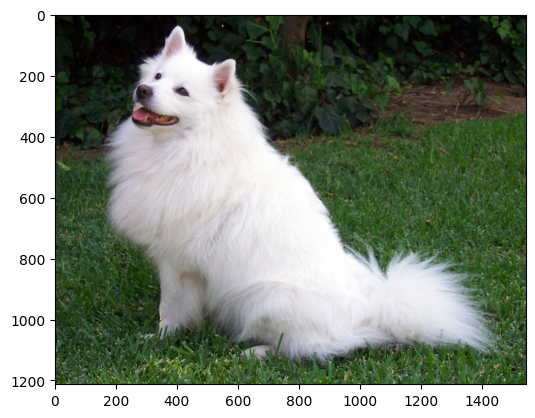

In [ ]:
from PIL import Image
import requests

import matplotlib.pyplot as plt

url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
test_image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(test_image)
plt.show()

We can verify the pretrained network by letting it predict the top *n* classes, such as this:

In [ ]:
def load_as_batch(img: Image):
    img_transformed = preprocess(test_image)
    batch = torch.unsqueeze(img_transformed, 0)
    return batch


def predict_model(img: Image, m=model):
    batch = load_as_batch(img)
    prediction = m(batch).squeeze(0).softmax(0)
    return prediction


def top_n_classes(prediction: torch.Tensor, n: int = 5):
    classes = torch.topk(prediction, n).indices.tolist()
    return classes


def print_class_predicitons(prediction, top_n=5):
    classes = top_n_classes(prediction, n=top_n)
    for class_id in classes:
        score = prediction[class_id].item()
        category_name = weights.meta["categories"][class_id]
        print(f"{category_name}: {100 * score:.1f}%")


prediction = predict_model(test_image)
print_class_predicitons(prediction, top_n=5)

Eskimo dog: 0.4%
Samoyed: 0.4%
Siberian husky: 0.3%
West Highland white terrier: 0.3%
white wolf: 0.2%


# GradCAM

To compute the GradCAM method, we require the gradient activations of our (last) convolution layer.

To get an overview of our model architecture, we use a simple `print()` statement.

For the Resnet50 model, the last two blocks are a pooling layer, and the fully connected output layer. Therefore, up to everything but the last two modules are our convolution activations. Or in code: `list(model.children())[:-2]`

When using different architectures, this must be adapted!

In [ ]:
# Print Network Architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We use this insight to write a Wrapper around the ResNet50 Model, to acces the gradients.

In [ ]:
class ResNetWrapper(torch.nn.Module):
    """Adapted from https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82"""

    def __init__(self):
        super().__init__()
        self.model = resnet50(weights=weights)
        # Resnet50 specific: Everything up until -2 is Convolution
        self.features_conv = torch.nn.Sequential(*list(self.model.children())[:-2])
        self.gradients = None

    def activations_hook(self, grad):
        # The Hook gets executed during .backward(), when computing the gradients.
        # It receives the gradient as input, and saves it to the attribute.
        self.gradients = grad

    def forward(self, x):
        # Perform Comvolution
        x = self.features_conv(x)
        # Register the Hook
        h = x.register_hook(self.activations_hook)

        # Perform the rest of the model as it normally would
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        return x

    def get_activations_gradient(self):
        # simple getter
        return self.gradients

    def conv_activations(self, x):
        # return conv activations for gradcam
        return self.features_conv(x)


# Verify our Wrapper still works as expected
resnet_wrapper = ResNetWrapper()
prediction = predict_model(test_image, m=resnet_wrapper)
print_class_predicitons(prediction, top_n=10)

Eskimo dog: 0.4%
Samoyed: 0.4%
Siberian husky: 0.3%
West Highland white terrier: 0.3%
white wolf: 0.2%
black-footed ferret: 0.2%
malamute: 0.2%
American Staffordshire terrier: 0.2%
planetarium: 0.2%
kuvasz: 0.2%


/tmp/ipython-input-1143419176.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


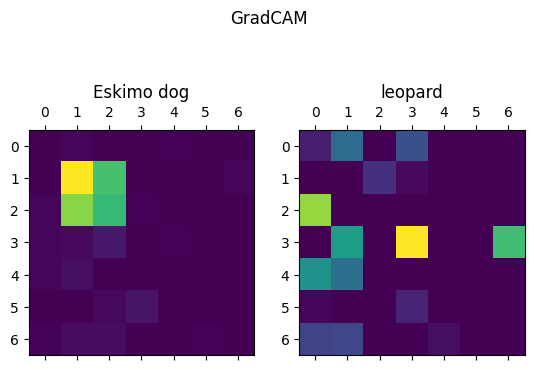

In [ ]:
import numpy as np


def cam_fn(_pred, class_id, _img):
    """Adapted from https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82"""
    pred = _pred.clone()

    # Pool Gradients
    pred[class_id].backward(retain_graph=True)
    gradients = resnet_wrapper.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight Activation by Gradient
    activations = resnet_wrapper.conv_activations(_img).detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap.numpy()


# Get GradCAMs for most and least relevant classes
batch = load_as_batch(test_image)
classes = top_n_classes(prediction, n=1000)
cam_class_0 = cam_fn(prediction, classes[0], batch).squeeze()
cam_class_1 = cam_fn(prediction, classes[-1], batch).squeeze()

# Show GradCAM
fig, axs = plt.subplots(1, 2)
fig.suptitle("GradCAM")
axs[0].matshow(cam_class_0)
axs[0].set_title(weights.meta["categories"][classes[0]])
axs[1].matshow(cam_class_1)
axs[1].set_title(weights.meta["categories"][classes[-1]])
plt.show()

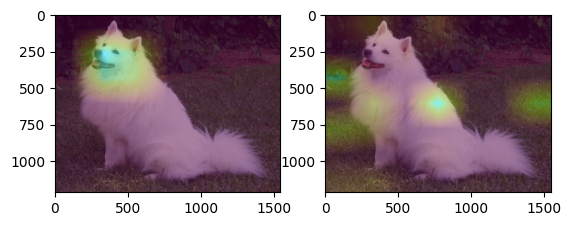

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def overlay_cam(cam, img=test_image):
    # Bilinear Interpolation to get small CAM to same size as Image
    cam = cv2.resize(cam, img.size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)
    image_with_heatmap = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)
    return image_with_heatmap


overlay_0 = overlay_cam(cam_class_0)
overlay_1 = overlay_cam(cam_class_1)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(overlay_0)
axs[1].imshow(overlay_1)
plt.show()

# Feature Visualization


For Feature Visualization, we want to generate an Image, maximizing the Activation of a specific Neuron / Layer or even Class.

To do this, we start from a randomly noised image.

torch.Size([1, 3, 224, 224])


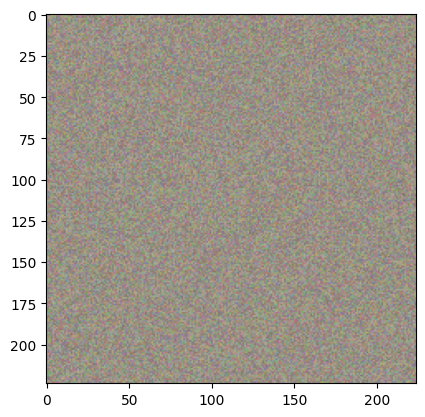

In [ ]:
def inverse_transform(_img):
    """Inverse Trnasform network input back to image space"""
    img = _img.squeeze().detach()
    mean = torch.tensor(weights.transforms().mean)[:, None, None]
    std = torch.tensor(weights.transforms().std)[:, None, None]
    img = img * std + mean
    img = torch.swapaxes(img, 0, -1)
    return img


# Create Random Noise Map like an Input Image
batch = load_as_batch(test_image)
noise_base = torch.rand_like(batch)
print(noise_base.shape)

# Visualize the ranom noise
img = inverse_transform(noise_base)
plt.imshow(img)
plt.show()

We create small (Sequential) networks, which correspond to our Resnet up until the 2nd to last and last convolution layer.

Note: This formulation is computationally highly inefficient and requires multiple network passes. Ideally we would save the network activations during a single forward pass.

In [ ]:
act_something = torch.nn.Sequential(*list(model.children())[:-6])
act_0 = torch.nn.Sequential(*list(model.children())[:-5])
act_1 = torch.nn.Sequential(*list(model.children())[:-4])
act_2 = torch.nn.Sequential(*list(model.children())[:-3])
act_3 = torch.nn.Sequential(*list(model.children())[:-2])
act_something(batch).shape, act_0(batch).shape, act_1(batch).shape, act_2(batch).shape, act_3(batch).shape

(torch.Size([1, 64, 56, 56]),
 torch.Size([1, 256, 56, 56]),
 torch.Size([1, 512, 28, 28]),
 torch.Size([1, 1024, 14, 14]),
 torch.Size([1, 2048, 7, 7]))

100%|██████████| 300/300 [00:14<00:00, 20.53it/s]


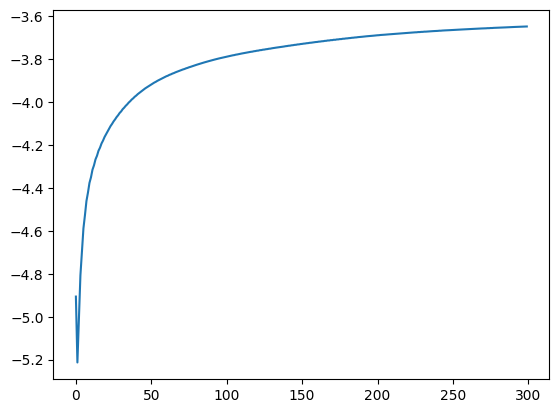

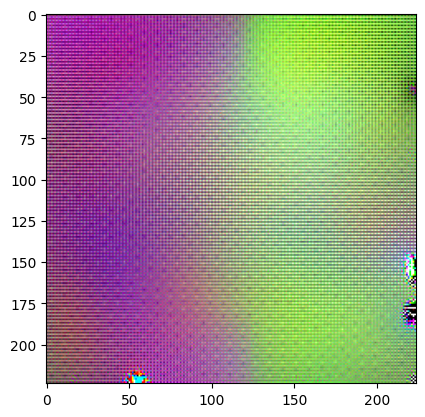

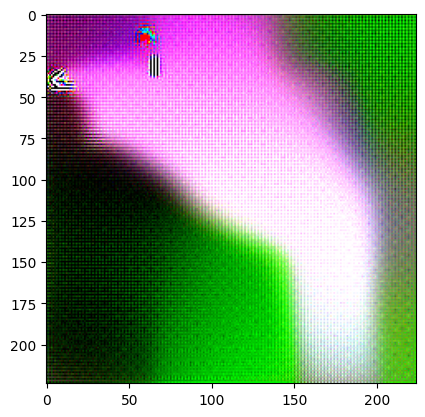

In [ ]:
import tqdm


def optimize_activation(noise_base_, max_iter=300, lr=0.2):
    noise_base = noise_base_.clone()
    losses = []
    for _ in tqdm.tqdm(range(max_iter)):
        noise_base.requires_grad_()
        loss = 0

        # Very Inefficient to do Multiple runs
        for act in [act_something]:
            activations = act(noise_base)
            # MAE, but MSE might also be interesting
            loss += -torch.mean(torch.abs(activations))
        losses.append(loss.item())
        grad = torch.autograd.grad(loss, noise_base)[0]

        # Normalize Gradients
        noise_base.data += lr * grad / (torch.std(grad) + 1e-8)
    return noise_base, losses


batch = load_as_batch(test_image)
noise_base = torch.rand_like(batch)

optimized_noise_base, losses = optimize_activation(noise_base)

optimized_dog, losses = optimize_activation(batch)

plt.plot(losses)
plt.show()

img = inverse_transform(optimized_noise_base)
plt.imshow(img)
plt.show()

img = inverse_transform(optimized_dog)
plt.imshow(img)
plt.show()

# Transformer and Attention

We use a copy of https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_GradCAM_Visualization.ipynb to work with OpenAI's CLIP Transformer and Highlight the Attention Mapping.

The CLIP Model specialty is the shared latent space for image and text encoding, allowing us to investigate, which parts of an image strongly align with a given caption.

In [ ]:
# @title Dependencies
# !pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git -q

import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00


### Helper functions
We define some helper functions.

In [ ]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x


# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02 * max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap("jet")
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = (
        1 * (1 - attn_map**0.7).reshape(attn_map.shape + (1,)) * img
        + (attn_map**0.7).reshape(attn_map.shape + (1,)) * attn_map_c
    )
    return attn_map


def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()


def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.0

### GradCAM: Gradient-weighted Class Activation Mapping

This gradCAM implementation registers a forward hook on the model at the specified layer. This allows us to save the intermediate activations and gradients at that layer.

To visualize which parts of the image activate for a given caption, we use the caption as the target label and backprop through the network using the image as the input. In the case of CLIP models with resnet encoders, we save the activation and gradients at the layer before the attention pool, i.e., layer4.


In [ ]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module, input: torch.Tensor, target: torch.Tensor, layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam, input.shape[2:], mode="bicubic", align_corners=False
    )

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

/tmp/ipython-input-1822314378.py:12: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attn_map = filters.gaussian_filter(attn_map, 0.02 * max(img.shape[:2]))


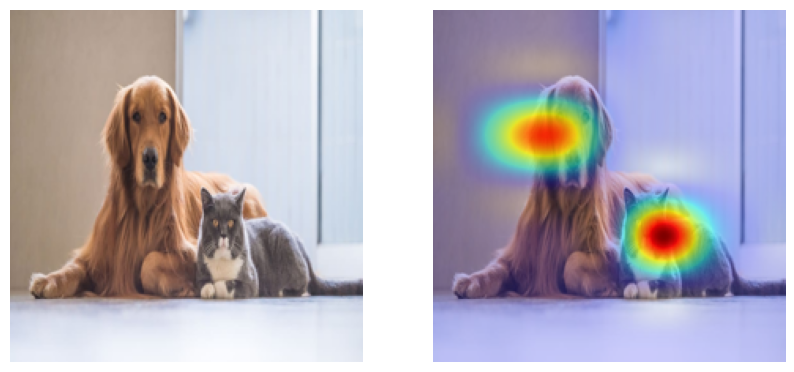

In [ ]:
# @markdown #### Image & Caption settings
image_url = "https://images2.minutemediacdn.com/image/upload/c_crop,h_706,w_1256,x_0,y_64/f_auto,q_auto,w_1100/v1554995050/shape/mentalfloss/516438-istock-637689912.jpg"  # @param {type:"string"}

image_caption = "there is a plane flying in the sky"  # @param {type:"string"}
# @markdown ---
# @markdown #### CLIP model settings
clip_model = "RN50"  # @param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4"  # @param ["layer4", "layer3", "layer2", "layer1"]
# @markdown ---
# @markdown #### Visualization settings
blur = True  # @param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

# Download the image from the web.
image_path = "image.png"
urllib.request.urlretrieve(image_url, image_path)

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer),
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)